In [1]:
# started 9-4-2025

In [54]:
import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt

from meteostat import Point, Daily
from datetime import datetime, timedelta
import time
import requests

In [55]:
fires = pd.read_csv("fires.csv")

In [65]:
socal_fires = fires[(fires["STATE"] == "CA") & (fires["LATITUDE"] <= 35) & (fires["FIRE_SIZE"] >= 2) & (fires["FIRE_YEAR"] >= 2005)]

In [57]:
socal_fires.head()

,OBJECTID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,CONT_DATE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,STATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,COUNTY,FIRE_NAME
109,110,2005,2453540.5,170,2453540.5,170.0,10.0,C,CA,2.0,Equipment Use,33.718889,-117.433611,NaN,SADDLE
154,155,2005,2453411.5,41,2453411.5,41.0,3.0,B,CA,5.0,Debris Burning,34.748333,-119.410278,NaN,APACHE
177,178,2005,2453544.5,174,2453544.5,174.0,4.2,B,CA,2.0,Equipment Use,34.466667,-119.828333,NaN,FAIRVIEW
1052,1053,2005,2453559.5,189,2453559.5,189.0,3.0,B,CA,9.0,Miscellaneous,34.479444,-118.768611,NaN,SWIM
1281,1282,2005,2453582.5,212,2453582.5,212.0,2.0,B,CA,1.0,Lightning,33.110833,-116.847222,NaN,PAMO


In [58]:
socal_fires.shape

(2926, 15)

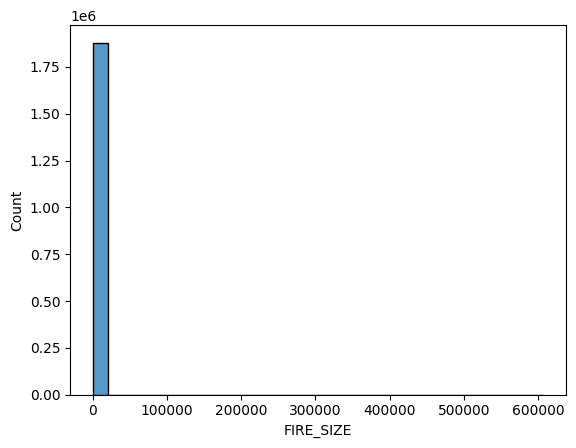

In [59]:
sns.histplot(data=fires, x="FIRE_SIZE", bins=30, kde=False)
plt.show()

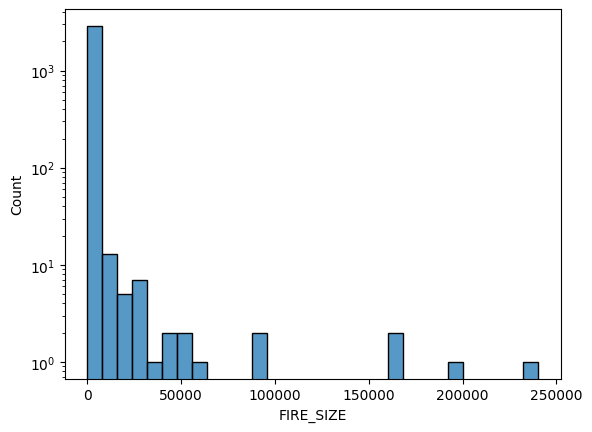

In [60]:
sns.histplot(data=socal_fires, x="FIRE_SIZE", bins=30, kde=False)
plt.yscale("log")
plt.show()

In [61]:
big_fires = socal_fires[(socal_fires["FIRE_SIZE"] >= 100000)]

In [62]:
big_fires.head()

,OBJECTID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,CONT_DATE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,STATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,COUNTY,FIRE_NAME
14835,14836,2006,2453982.5,247,2454038.5,303.0,162702.0,G,CA,5.0,Debris Burning,34.632222,-118.769722,Ventura,DAY
24834,24835,2007,2454285.5,185,2454345.5,245.0,240207.0,G,CA,2.0,Equipment Use,34.779167,-120.090000,Santa Barbara,ZACA
26363,26364,2007,2454394.5,294,2454404.5,304.0,197990.0,G,CA,9.0,Miscellaneous,33.074444,-116.711111,San Diego,WITCH
41296,41297,2009,2455069.5,238,2455096.5,265.0,160371.0,G,CA,7.0,Arson,34.242500,-118.188889,Los Angeles,STATION


In [63]:
def julian_to_date(jd):
    if isinstance(jd, float):  # Julian float
        unix_epoch = datetime(1970, 1, 1)
        dt = unix_epoch + timedelta(days=(jd - 2440587.5))
        return dt.date()
    elif isinstance(jd, pd.Timestamp):  # Already datetime
        return jd.date()
    else:
        return None
    

def fetch_weather_open_meteo(socal_fires):
    weather_data = []

    for idx, row in socal_fires.iterrows():
        try:
            lat = float(row["LATITUDE"])
            lon = float(row["LONGITUDE"])
            date = julian_to_date(row["DISCOVERY_DATE"])
            if date is None:
                raise ValueError("Invalid date")

            # 1 day window
            start_date = str(date - pd.Timedelta(days=1))
            end_date = str(date + pd.Timedelta(days=1))

            url = (
                "https://archive-api.open-meteo.com/v1/archive?"
                f"latitude={lat}&longitude={lon}"
                f"&start_date={start_date}&end_date={end_date}"
                "&daily=temperature_2m_max,relative_humidity_2m_max,precipitation_sum,windspeed_10m_max"
                "&timezone=America/Los_Angeles"
            )

            resp = requests.get(url, timeout=10)
            data = resp.json()

            if "daily" in data and len(data["daily"]["time"]) > 0:
                temp_max_C = data["daily"]["temperature_2m_max"][0]
                humidity = data["daily"]["relative_humidity_2m_max"][0]
                precip_mm = data["daily"]["precipitation_sum"][0]
                wind_kmh = data["daily"]["windspeed_10m_max"][0]

                weather_data.append({
                    "OBJECTID": row["OBJECTID"],
                    "temp_max_F": temp_max_C * 9/5 + 32 if temp_max_C is not None else None,
                    "humidity_pct": humidity,
                    "precip_in": precip_mm / 25.4 if precip_mm is not None else None,
                    "windspeed_mph": wind_kmh / 1.609 if wind_kmh is not None else None
                })
            else:
                weather_data.append({
                    "OBJECTID": row["OBJECTID"],
                    "temp_max_F": None,
                    "humidity_pct": None,
                    "precip_in": None,
                    "windspeed_mph": None
                })

        except Exception as e:
            print(f"Error for OBJECTID {row['OBJECTID']}: {e}")
            weather_data.append({
                "OBJECTID": row["OBJECTID"],
                "temp_max_F": None,
                "humidity_pct": None,
                "precip_in": None,
                "windspeed_mph": None
            })

        time.sleep(0.05)  # polite pause

    return pd.DataFrame(weather_data)

In [64]:
socal_fires_weather_fetched = fetch_weather_open_meteo(socal_fires)

In [67]:
socal_fires_weather = socal_fires_weather_fetched

In [68]:
socal_fires_weather

,OBJECTID,temp_max_F,humidity_pct,precip_in,windspeed_mph
0,110,73.04,89,0.062992,6.028589
1,155,58.46,79,0.000000,4.536979
2,178,77.54,76,0.000000,15.972654
3,1053,82.76,86,0.000000,6.028589
4,1282,87.62,88,0.000000,8.763207
...,...,...,...,...,...
2921,1880367,85.64,78,0.000000,7.271597
2922,1880400,65.84,91,0.000000,6.774394
2923,1880420,66.56,90,0.015748,11.249223
2924,1880428,65.84,44,0.000000,7.147296


In [71]:
socal_fires = socal_fires[["OBJECTID", "FIRE_YEAR", "DISCOVERY_DATE", "FIRE_SIZE", "STAT_CAUSE_DESCR", "LATITUDE", "LONGITUDE"]]
socal_fires = socal_fires.reset_index(drop=True)

In [72]:
socal_fires

,OBJECTID,FIRE_YEAR,DISCOVERY_DATE,FIRE_SIZE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE
0,110,2005,2453540.5,10.0,Equipment Use,33.718889,-117.433611
1,155,2005,2453411.5,3.0,Debris Burning,34.748333,-119.410278
2,178,2005,2453544.5,4.2,Equipment Use,34.466667,-119.828333
3,1053,2005,2453559.5,3.0,Miscellaneous,34.479444,-118.768611
4,1282,2005,2453582.5,2.0,Lightning,33.110833,-116.847222
...,...,...,...,...,...,...,...
2921,1880367,2009,2455012.5,2.0,Equipment Use,33.297738,-117.003073
2922,1880400,2009,2454954.5,73.0,Missing/Undefined,33.892120,-117.079065
2923,1880420,2010,2455345.5,50.0,Missing/Undefined,32.906591,-116.942448
2924,1880428,2013,2456402.5,4.5,Children,34.633333,-118.966666


In [73]:
full_fires = pd.concat([socal_fires,socal_fires_weather], axis=1)

In [74]:
full_fires

,OBJECTID,FIRE_YEAR,DISCOVERY_DATE,FIRE_SIZE,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,OBJECTID,temp_max_F,humidity_pct,precip_in,windspeed_mph
0,110,2005,2453540.5,10.0,Equipment Use,33.718889,-117.433611,110,73.04,89,0.062992,6.028589
1,155,2005,2453411.5,3.0,Debris Burning,34.748333,-119.410278,155,58.46,79,0.000000,4.536979
2,178,2005,2453544.5,4.2,Equipment Use,34.466667,-119.828333,178,77.54,76,0.000000,15.972654
3,1053,2005,2453559.5,3.0,Miscellaneous,34.479444,-118.768611,1053,82.76,86,0.000000,6.028589
4,1282,2005,2453582.5,2.0,Lightning,33.110833,-116.847222,1282,87.62,88,0.000000,8.763207
...,...,...,...,...,...,...,...,...,...,...,...,...
2921,1880367,2009,2455012.5,2.0,Equipment Use,33.297738,-117.003073,1880367,85.64,78,0.000000,7.271597
2922,1880400,2009,2454954.5,73.0,Missing/Undefined,33.892120,-117.079065,1880400,65.84,91,0.000000,6.774394
2923,1880420,2010,2455345.5,50.0,Missing/Undefined,32.906591,-116.942448,1880420,66.56,90,0.015748,11.249223
2924,1880428,2013,2456402.5,4.5,Children,34.633333,-118.966666,1880428,65.84,44,0.000000,7.147296


In [ ]:
#full_fires.to_csv("pt2_full_fires_socal.csv", index=False)